Epoch 1/30
45/45 [==============================] - 3s 31ms/step - loss: 0.2979 - val_loss: 1.2456
Epoch 2/30
45/45 [==============================] - 1s 29ms/step - loss: 0.2764 - val_loss: 1.2636
Epoch 3/30
45/45 [==============================] - 1s 32ms/step - loss: 0.2747 - val_loss: 1.3440
Epoch 4/30
45/45 [==============================] - 1s 30ms/step - loss: 0.2711 - val_loss: 1.3241
Epoch 5/30
45/45 [==============================] - 1s 27ms/step - loss: 0.2703 - val_loss: 1.2895
Epoch 6/30
45/45 [==============================] - 2s 34ms/step - loss: 0.2691 - val_loss: 1.3330
Epoch 7/30
45/45 [==============================] - 2s 38ms/step - loss: 0.2617 - val_loss: 1.4629
Epoch 8/30
45/45 [==============================] - 1s 32ms/step - loss: 0.2638 - val_loss: 1.7136
Epoch 9/30
45/45 [==============================] - 2s 41ms/step - loss: 0.2608 - val_loss: 1.6360
Epoch 10/30
45/45 [==============================] - 2s 39ms/step - loss: 0.2599 - val_loss: 1.7541
Epoch 11/

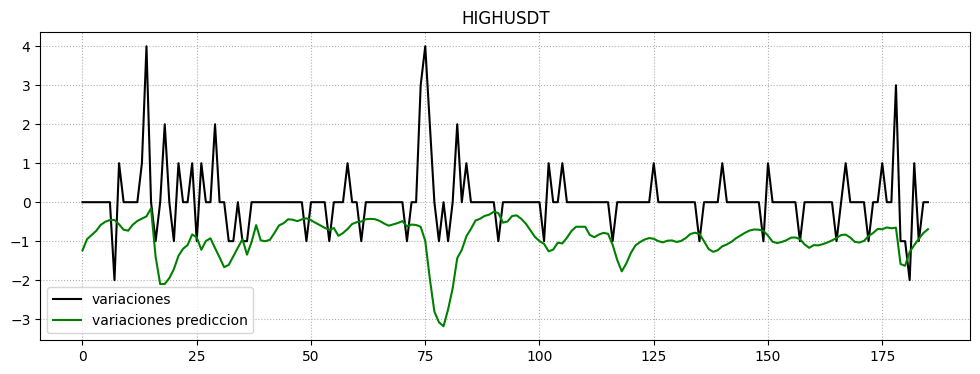

MSE: 1.7518955556436446


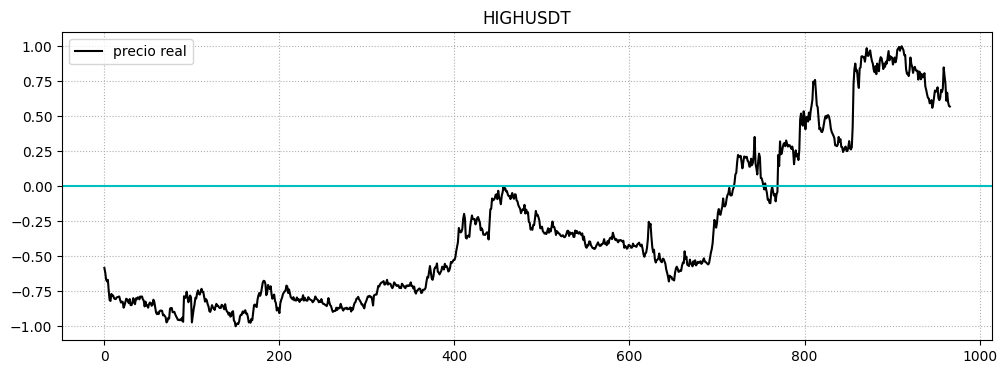

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
from binance import Client
import talib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, LSTM, Input, Activation
import numpy as np
from sklearn.metrics import mean_squared_error
import keras
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

symbol =  str.upper('high'+'USDT')
client = Client("qycthSI8s5HH0b95MxH3lFKPPUeZu8mCSgztp00x2d7SdHmfOp2U9qBeCCbxPyDg", 
                "zeJqYkyWzBIdGDMmyfUnofQiThirgEgOCDYvS3rzcq4yle1afD7YEQkciCI43yNs")

#######################################################################################
# Carga historial

timeframe='30m'
backcandles = 40 
historical_data = client.get_historical_klines(symbol, timeframe)
data = pd.DataFrame(historical_data)
data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
data['Open Time'] = pd.to_datetime(data['Open Time']/1000, unit='s')
data['Close Time'] = pd.to_datetime(data['Close Time']/1000, unit='s')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, axis=1)

#######################################################################################
# Indicadores

def get_bollinger_bands(df):
    mult = 2.0
    length = 20
    close = df['Close']
    basis = talib.SMA(close, length)
    dev = mult * talib.STDDEV(close, length)
    df['upper'] = basis + dev
    df['lower'] = basis - dev
    return df

def vwap(data):
    v = data['Volume'].values
    tp = (data['Low'] + data['Close'] + data['High']).div(3).values
    data['Vwap']=(tp * v).cumsum() / v.cumsum()
    return data

def checkhl(data_back, data_forward, hl):
    if hl == 'high' or hl == 'High':
        ref = data_back[len(data_back)-1]
        for i in range(len(data_back)-1):
            if ref < data_back[i]:
                return 0
        for i in range(len(data_forward)):
            if ref <= data_forward[i]:
                return 0
        return 1
    if hl == 'low' or hl == 'Low':
        ref = data_back[len(data_back)-1]
        for i in range(len(data_back)-1):
            if ref > data_back[i]:
                return 0
        for i in range(len(data_forward)):
            if ref >= data_forward[i]:
                return 0
        return 1
    
def pivot(data, LBL, LBR, highlow):
    df=data.copy()
    left = []
    right = []
    pivots=[]
    df['pivot']=0.0
    i=0
    last_value=0.0
    for index, row in df.iterrows():
        pivots.append(0.0)
        if i < LBL + 1:
            left.append(df.Close[i])
        if i > LBL:
            right.append(df.Close[i])
        if i > LBL + LBR:
            left.append(right[0])
            left.pop(0)
            right.pop(0)
            if checkhl(left, right, highlow):
                pivots[i - LBR] = df.Close[i - LBR]
                last_value = df.Close[i - LBR]
        df.at[index,'pivot'] = last_value
        i=i+1
    return df['pivot']

#data['RSI']=ta.rsi(data.Close, length=15)
#data['EMAF']=ta.ema(data.Close, length=20)
#data['EMAM']=ta.ema(data.Close, length=50)
#data['EMAS']=ta.ema(data.Close, length=200)
data['macd'], data['macd_signal'], data['macd_hist'] = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data=get_bollinger_bands(data)
data['pivot_high'] = pivot(data, 24, 24, 'high')
data['pivot_low'] = pivot(data, 24, 24, 'low')
data['TARGET'] = data['Close'].shift(-1)
#data['TARGET'] = (data['TARGET'] - data['TARGET'].median())  / (data['TARGET'].quantile(0.75) - data['TARGET'].quantile(0.25))
data['TARGET'] =  np.where(data.Close > data.Close.shift(1)*1.04,4,
                 (np.where(data.Close > data.Close.shift(1)*1.03,3, 
                 (np.where(data.Close > data.Close.shift(1)*1.02,2, 
                 (np.where(data.Close > data.Close.shift(1)*1.01,1, 
                 (np.where(data.Close < data.Close.shift(1)*0.96,-4,
                 (np.where(data.Close < data.Close.shift(1)*0.97,-3,
                 (np.where(data.Close < data.Close.shift(1)*0.98,-2,
                 (np.where(data.Close < data.Close.shift(1)*0.99,-1,0)))))))))))))))

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Open Time','Close Time','Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume','Number of Trades',
          'Ignore','index'], axis=1, inplace=True)
cantidad_campos_entrenar=len(data.columns)-1
data_set = data
pd.set_option('display.max_columns', None)
#######################################################################################
# formatea datos

#data_set_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(data_set)
#data_set_scaled = StandardScaler().fit_transform(data_set)
data_set_scaled = RobustScaler().fit_transform(data_set)

# multiple feature from data provided to the model
X = []
for j in range(cantidad_campos_entrenar):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])
#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
# split data into train test sets
splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

#######################################################################################
# Entrena o carga modelo

np.random.seed(10)
lstm_input = Input(shape=(backcandles, cantidad_campos_entrenar), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)

#model = keras.models.load_model('modelos/model'+symbol+'.h5')

# Grafica

y_pred = model.predict(X_test)
deriv_y_pred = np.diff(y_pred, axis=0)
deriv_y_pred2 = np.diff(deriv_y_pred, axis=0)
deriv_y_pred_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(deriv_y_pred)
deriv_y_pred_scaled2 = MinMaxScaler(feature_range=(-1, 1)).fit_transform(deriv_y_pred2)
deriv_y_pred_scaled = np.insert(deriv_y_pred_scaled, 0, 0.0, axis=0)#para mover 1 posicion hacia adelante
deriv_y_pred_scaled2 = np.insert(deriv_y_pred_scaled2, 0, 0.0, axis=0)#para mover 1 posicion hacia adelante
deriv_y_pred_scaled2 = np.insert(deriv_y_pred_scaled2, 0, 0.0, axis=0)#para mover 1 posicion hacia adelante
array = data['Close'].to_numpy()
array=array.reshape(-1, 1)
precio_real_escalado = MinMaxScaler(feature_range=(-1, 1)).fit_transform(array)

plt.figure(figsize=(12,4))
plt.plot(y_test, color = 'black', label = 'variaciones')
plt.plot(y_pred, color = 'green', label = 'variaciones prediccion')
#plt.plot(deriv_y_pred_scaled2, color = 'red', label = 'pred deriv 2da')
#plt.xlim(60)
umbralalto = 0.6
umbralbajo = -0.6
#plt.axhline(y = umbralalto, color = 'c', linestyle = '-')
#plt.axhline(y = umbralbajo, color = 'c', linestyle = '-')
plt.legend()
plt.title(symbol)
plt.grid(linestyle='dotted')
plt.show()
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

########## precio real

plt.figure(figsize=(12,4))
plt.plot(precio_real_escalado, color = 'black', label = 'precio real')
plt.axhline(y = 0, color = 'c', linestyle = '-')
plt.legend()
plt.title(symbol)
plt.grid(linestyle='dotted')
plt.show()

